In [130]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from data.prepare_data import *
from data.prepare_word2vec_ed import *
from manual_labeling.labeled_data import SLOVA_PO_B, KONCOVKY_PRID_JMEN
from similarities.text_similarities import levenshtein_similarity, levenshtein_similarity_with_threshold
import matplotlib.pyplot as plt

In [131]:
model = Word2Vec.load('utils/word2vec.model')

In [132]:
ps_data = get_ps_data()
slovab = {'name':'vyjmenovane_slova_b', 'data': get_vyjmenovana_slova_po_b(ps_data), 'labels': SLOVA_PO_B}
koncprid = {'name':'koncovky_prid_jmena', 'data': get_data_by_knowledge_component(ps_data, 36), 'labels': KONCOVKY_PRID_JMEN}
datasets = [slovab, koncprid]

In [178]:
dataset = datasets[0]

In [179]:
# ..to_csv('data/processed/vyjmenovana_slova_po_b.csv', index=False)

# words which are also in my word2vec model and are labeled
_, word2vec_data = get_word2vec_items(model, dataset['data'])
label_data(word2vec_data, dataset['labels'])
# some questions with same text are labeled in more question_ids
word2vec_data.sort_values(['question_id'], inplace=True)
word2vec_data.drop_duplicates(['question'], inplace=True)

labeled_word2vec_data = word2vec_data[word2vec_data['manual_label'] != 0]

# Adjrandindex results - the similarity (based on pearson) is computed only from labeled answers

In [180]:
# all answers which are labeled
dataset['data']['full_solution'] = get_solutions(dataset['data'], 'full')
label_data(dataset['data'], dataset['labels'])
labeled_data = dataset['data'][dataset['data']['manual_label'] != 0]

# all answers which are also in my word2vec model and are labeled
labeled_data = labeled_data.loc[labeled_data['question_id'].isin(labeled_word2vec_data['question_id'])]

In [181]:
# same assignment has two ids in the dataset => replace the id
# labeled_slova_po_b[labeled_slova_po_b['question'] == 'b_otop'].question_id.unique()
# -> array([6387,  237])
# labeled_slova_po_b.loc[labeled_slova_po_b['question_id'] == 237] = 6387

In [182]:
### ED ###
editdistance = create_edit_similarity_matrix(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity)
editdistance = editdistance.astype(float)

### word2vec ###
word2vec = create_word2vec_similarity_matrix(model, labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'])

In [183]:
### Pearson ###

# count similarity based on whole dataset (all answers)
correctness_matrix = reshape_to_correctness_matrix(dataset['data'])
pearson1 = correctness_matrix_to_similarity_matrix('doublepearson', correctness_matrix)
pearson2 = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix)

# all answers which are labeled and in word2vec model
labeled = pearson2.columns.isin(labeled_word2vec_data['question_id'].unique())
pearson2 = pearson2.loc[labeled, labeled]
from similarities.performance_similarities import drop_nans
pearson2 = drop_nans(pearson2)

# same questions in all models - pearson could have NaN values which are not ok for clustering and had to be dropped
pearson1_from_pearson = pearson1.columns.isin(pearson2.columns)
editdistance_from_pearson = editdistance.columns.isin(pearson2.columns)
word2vec_from_pearson = word2vec.columns.isin(pearson2.columns)
pearson1 = pearson1.loc[pearson1_from_pearson, pearson1_from_pearson]
editdistance = editdistance.loc[editdistance_from_pearson, editdistance_from_pearson]
word2vec = word2vec.loc[word2vec_from_pearson, word2vec_from_pearson]

In [184]:
def create_edit_similarity_matrix_with_threshold(index, solutions, similarity_function, M=4):
    dataframe = pd.DataFrame(index=index,columns=index)
    for i, j in zip(solutions, index):
        for k, l in zip(solutions, index):
                dataframe.loc[j, l] = similarity_function(i, k, M)
    return dataframe

In [185]:
editdistance_m_3 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 3)

In [186]:
editdistance_m_4 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, 4)

In [187]:
editdistance_m_5 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=5)

In [188]:
editdistance_m_6 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=6)

In [189]:
editdistance_m_7 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=7)

In [190]:
editdistance_m_8 = create_edit_similarity_matrix_with_threshold(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity_with_threshold, M=8)

In [191]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='precomputed', linkage='complete')

In [211]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='euclidean', linkage='ward')

In [212]:
pearson1 = 1 - pearson1
pearson2 = 1 - pearson2
editdistance = 1 - editdistance
word2vec = 1 - word2vec
editdistance_m_3 = 1 - editdistance_m_3
editdistance_m_4 = 1 - editdistance_m_4
editdistance_m_5 = 1 - editdistance_m_5
editdistance_m_6 = 1 - editdistance_m_6
editdistance_m_7 = 1 - editdistance_m_7
editdistance_m_8 = 1 - editdistance_m_8

In [213]:
pearson1.head()

question_id,25,26,27,28,29,30,42,43,44,63,...,2264,2278,6346,6353,6354,6364,6375,6376,6385,6386
question_id,,,,,,,,,,,,,,,,,,,,,
25,1.000000,0.370401,0.225158,0.229112,0.338657,0.111969,0.032979,-0.108764,0.162846,0.100863,...,0.051040,0.109187,0.056369,0.198789,0.177169,0.247831,0.033441,-0.023404,0.112483,0.064437
26,0.370401,1.000000,0.261922,0.409719,0.170644,0.038056,0.078058,0.009353,0.121460,0.116930,...,0.068478,0.087490,-0.010383,0.196936,0.099162,0.078716,-0.054231,0.044838,0.037215,0.045148
27,0.225158,0.261922,1.000000,0.161713,0.120460,0.067447,0.075658,0.078254,0.095227,-0.098669,...,0.053767,0.135846,0.090857,0.082554,0.108285,-0.064198,0.063869,-0.111820,-0.003962,-0.035738
28,0.229112,0.409719,0.161713,1.000000,0.329504,0.203005,0.112649,-0.103928,0.123751,0.091816,...,0.065516,0.110350,0.127348,0.197418,0.128749,0.151020,0.062698,0.105436,0.212551,0.108274
29,0.338657,0.170644,0.120460,0.329504,1.000000,0.256852,0.029034,-0.126503,0.096928,0.026058,...,0.001475,0.035421,0.119717,0.217074,0.118614,-0.042547,-0.010592,-0.045658,-0.017599,-0.054798


In [194]:
# kmeans.fit_transform(pearson1)
clustering.fit_predict(pearson1)

array([2, 2, 2, 2, 2, 3, 0, 1, 6, 6, 2, 2, 1, 2, 5, 3, 5, 5, 7, 7, 0, 4,
       3, 4, 4, 4, 4, 1, 6, 6, 4, 0, 2, 2, 4, 1, 6, 6, 4])

In [195]:
clustering.fit_predict(pearson2)

array([0, 0, 1, 0, 0, 0, 4, 6, 3, 3, 0, 2, 2, 0, 7, 1, 7, 7, 1, 1, 4, 5,
       1, 5, 5, 6, 5, 6, 7, 3, 1, 4, 2, 0, 7, 6, 3, 3, 5])

In [196]:
clustering.fit_predict(word2vec)

array([1, 4, 4, 1, 1, 4, 1, 1, 4, 7, 2, 0, 6, 0, 0, 6, 6, 3, 6, 6, 5, 3,
       3, 3, 3, 0, 0, 2, 2, 1, 5, 0, 0, 6, 7, 1, 4, 5, 0])

In [197]:
clustering.fit_predict(editdistance)

array([4, 4, 4, 4, 5, 5, 2, 3, 2, 2, 2, 1, 1, 1, 7, 7, 7, 7, 3, 3, 6, 0,
       0, 0, 6, 0, 0, 3, 3, 2, 6, 7, 1, 1, 2, 3, 2, 0, 0])

In [198]:
clusters = labeled_word2vec_data['manual_label'].unique()

In [199]:
len(clusters)

8

In [200]:
from sklearn.metrics import adjusted_rand_score

In [201]:
method = editdistance
X = method
question_ids = X.index

In [202]:
labeled_data = labeled_data.set_index('question_id')

In [203]:
ground_truth = np.array([labeled_data.at[question_id, 'manual_label'][0] for question_id in question_ids])

In [204]:
cluster_labels = clustering.fit_predict(editdistance)

In [205]:
adjusted_rand_score(ground_truth, cluster_labels)

0.6696944465470693

In [214]:
similarities = [('pearson', pearson2), ('dpearson', pearson1), ('word2vec', word2vec), ('defaultED', editdistance), ('ED with M=3', editdistance_m_3), ('ED with M=4', editdistance_m_4), ('ED with M=5', editdistance_m_5), ('ED with M=6', editdistance_m_6), ('ED with M=7', editdistance_m_7), ('ED with M=8', editdistance_m_8)]
adj_randindex = []
for similarity_name, X in similarities:
    print(similarity_name)
    ground_truth = np.array([labeled_data.at[question_id, 'manual_label'][0] for question_id in X.index])
    cluster_labels = clustering.fit_predict(X)
    adj_randindex.append(round(adjusted_rand_score(ground_truth, cluster_labels), 2))

pearson
dpearson
word2vec
defaultED
ED with M=3
ED with M=4
ED with M=5
ED with M=6
ED with M=7
ED with M=8


In [215]:
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=8,
            pooling_func=<function mean at 0x7f02d02d4d90>)

In [175]:
# euclid koncovky rounded
adj_randindex

[0.12, 0.13, 0.5, 0.49, 0.12, 0.14, 0.2, 0.32, 0.26, 0.36]

In [167]:
# no euclid koncovky rounded
adj_randindex

[0.05, 0.13, 0.34, 0.48, -0.02, -0.03, 0.01, 0.09, 0.3, 0.31]

In [216]:
# euclid vyjmenovana slova rounded
adj_randindex

[0.34, 0.36, 0.38, 0.73, 0.21, 0.44, 0.52, 0.63, 0.64, 0.48]

In [208]:
# no euclid vyjmenovana slova rounded
adj_randindex

[0.29, 0.35, 0.25, 0.67, 0.11, 0.19, 0.23, 0.22, 0.38, 0.38]

In [217]:
similarities = [name for name, _ in similarities]
data = {'similarity': similarities, 'randindex': adj_randindex}
df = pd.DataFrame(data)
if dataset['name'] == 'vyjmenovane_slova_b':
    datasets[0]['randindex'] = df
else:
    datasets[1]['randindex'] = df

In [218]:
df.to_csv('randindex-vyjmenovanaslovab-clusteringeuclidean.csv')

In [34]:
%matplotlib inline

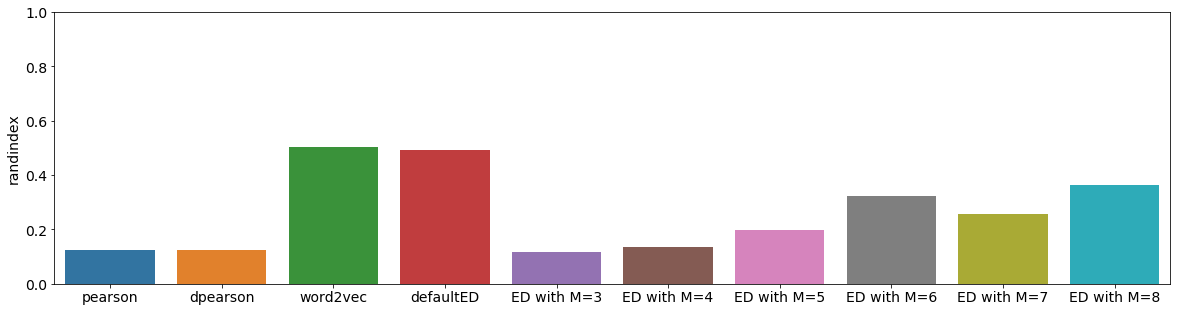

In [73]:
# df.plot(kind='bar', x='similarity', figsize=(8,5))
import seaborn as sns
sns_plot = sns.barplot(data=df, x='similarity', y='randindex')
fig = sns_plot.get_figure()
fig.set_size_inches(20,5)
sns_plot.set(ylim=(0, 1))
sns_plot.set_xlabel('')
sns_plot.set_ylabel('randindex', fontsize=14)
sns_plot.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('visualizations/seaborn/clustering_randindex-edit_distance_thresholds-%s.svg' % dataset['name'])

## Visualizing both barplots of two knowledge components in one figure

In [74]:
colors = ['blue','lightish blue','green','red']
colors.extend(['lightish red']*6)

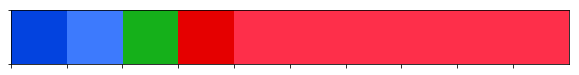

In [75]:
#https://xkcd.com/color/rgb/
sns.palplot(sns.xkcd_palette(colors))


In [76]:
colors = sns.xkcd_palette(colors)

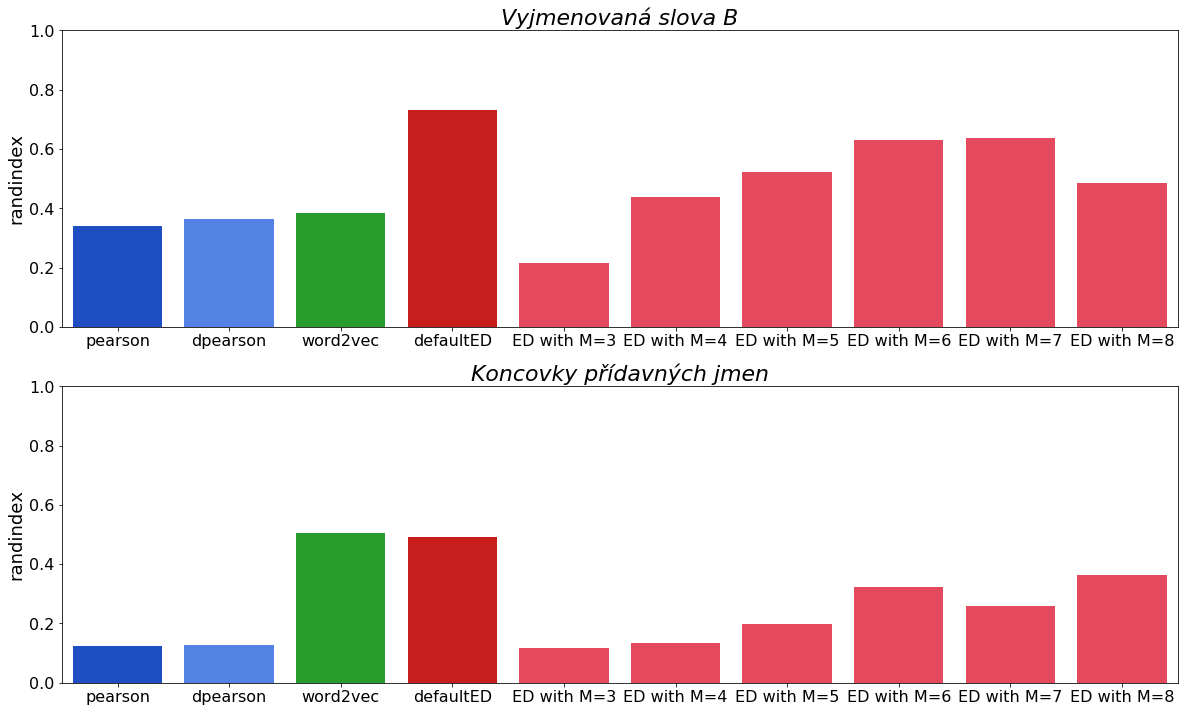

In [77]:
figure, (ax1,ax2) = plt.subplots(2,1)
figure.set_size_inches(20,12)
# colors = ['blue','orange','green','red']
# colors.extend(['indianred']*5)

a1 = sns.barplot(data=datasets[0]['randindex'], ax=ax1, x='similarity', y='randindex', palette=colors)
a1.set(ylim=(0, 1))
a1.set_xlabel('')
a1.set_ylabel('randindex', fontsize=18)
a1.tick_params(axis='both', which='major', labelsize=16)
a1.set_title('Vyjmenovaná slova B', fontsize=22, fontstyle='italic')

a2 = sns.barplot(data=datasets[1]['randindex'], ax=ax2, x='similarity', y='randindex', palette=colors)
a2.set(ylim=(0, 1))
a2.set_xlabel('')
a2.set_ylabel('randindex', fontsize=18)
a2.tick_params(axis='both', which='major', labelsize=16)
a2.set_title('Koncovky přídavných jmen', fontsize=22, fontstyle='italic')
plt.savefig('visualizations/seaborn/randindex-barplot.svg')
plt.show()

# Visualizing only labeled data

In [69]:
# dataset['data']['question_id'] = dataset['data'].index

In [92]:
data = dataset['data'][dataset['data']['question_id'].isin(pearson2.index)].drop_duplicates(['question_id'])

In [93]:
len(data)

66

In [94]:
data.reset_index(drop=True, inplace=True)

In [115]:
pearson1 = 1 - pearson1

In [116]:
pearson1.head()

question_id,1215,1217,1219,1220,1221,1222,1223,1224,1225,1226,...,4007,4008,6476,6483,6484,6486,6489,6491,6493,6494
question_id,,,,,,,,,,,,,,,,,,,,,
1215,1.000000,0.317177,0.212911,0.033091,0.194535,-0.120662,0.023714,0.116084,0.361917,0.421006,...,0.065526,-0.071449,-0.092310,-0.181333,-0.052356,-0.226046,0.092971,-0.184246,-0.185468,0.026411
1217,0.317177,1.000000,0.119037,-0.050037,0.237738,0.097352,0.339352,0.081469,0.227094,0.282984,...,-0.080251,0.404340,0.021521,-0.259206,0.084777,-0.263172,0.155636,0.180594,-0.240333,-0.055345
1219,0.212911,0.119037,1.000000,-0.035404,0.051396,-0.150460,0.033611,0.304485,0.348681,-0.083937,...,0.015296,0.105986,0.236833,-0.045532,-0.048855,-0.074927,0.007365,-0.107420,-0.177178,-0.156062
1220,0.033091,-0.050037,-0.035404,1.000000,-0.007982,-0.094089,0.034739,0.281443,0.291675,0.029845,...,-0.242773,0.052514,0.015863,-0.110445,-0.091851,-0.005122,-0.026190,-0.116793,0.093869,0.172138
1221,0.194535,0.237738,0.051396,-0.007982,1.000000,0.177479,0.110369,0.143760,0.181719,0.177058,...,-0.122907,0.063916,0.241344,-0.183550,0.097486,0.246338,0.408816,-0.020127,0.201594,0.188777


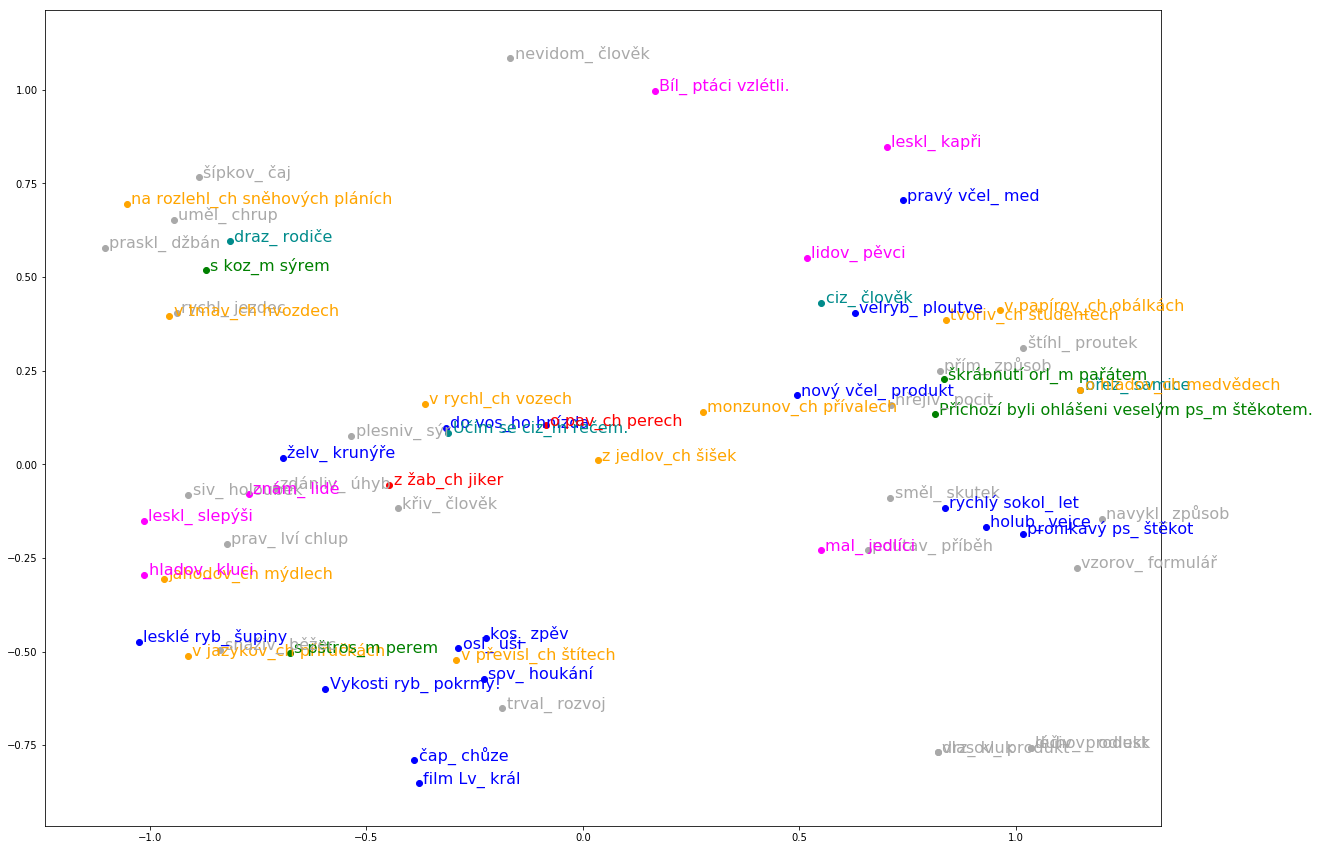

In [95]:
from sklearn.decomposition import PCA
from projections.base_projection import *
model = PCA(n_components=2)
result = model.fit_transform(pearson1)
# create a scatter plot of the projections
x_positions = result[:, 0]
y_positions = result[:, 1]

colors = ['blue', 'green', 'red', 'darkcyan', 'magenta', 'orange', 'darkgray', 'purple']

for i, row in data.iterrows():
    if row['manual_label'] != 0:
        plt.scatter(x_positions[i], y_positions[i], c=colors[row['manual_label'] - 1])
        plt.annotate(row['question'], xy=(x_positions[i]+0.01, y_positions[i]), color=colors[row['manual_label'] - 1], fontsize=16)
    else:
        plt.scatter(x_positions[i], y_positions[i], c='black')
        plt.annotate(row['question'], xy=(x_positions[i]+0.01, y_positions[i]), color='black')
plt.gcf().set_size_inches(20, 15)
# plt.title('dataset: Koncovky přídavných jmen, similarity measure: Pearson', fontsize=20, fontstyle='italic')
# plt.savefig('visualizations/pearson-vis-labeledkoncovky-fontsize16.svg')
plt.show()
# projection = Projection(x_positions, y_positions, data.copy(), data_name='pridjmena', model=model)
# projection.matplotlib_plot_with_manual_labels(figsize=(20,15), save_path='visualizations/editdistance-withthreshold-vis-%s.png' % dataset['name'], annotate=True)

In [12]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [14]:
editdistance.index = labeled_word2vec_data['solution']
word2vec.index = labeled_word2vec_data['solution']

In [43]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=len(dataset['labels']), affinity='euclidean', linkage='ward')

In [71]:
from scipy.cluster import hierarchy

In [72]:
children = model.children_

# Distances between each pair of children
# Since we don't have this information, we can use a uniform one for plotting
distance = np.arange(children.shape[0])

# The number of observations contained in each cluster level
no_of_observations = np.arange(2, children.shape[0]+2)

# Create linkage matrix and then plot the dendrogram
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

In [90]:
hierarchy.set_link_color_palette(None)

In [97]:
colors = ['blue', 'green', 'red', 'darkcyan', 'magenta', 'orange', 'darkgray', 'purple']
hierarchy.set_link_color_palette(colors)

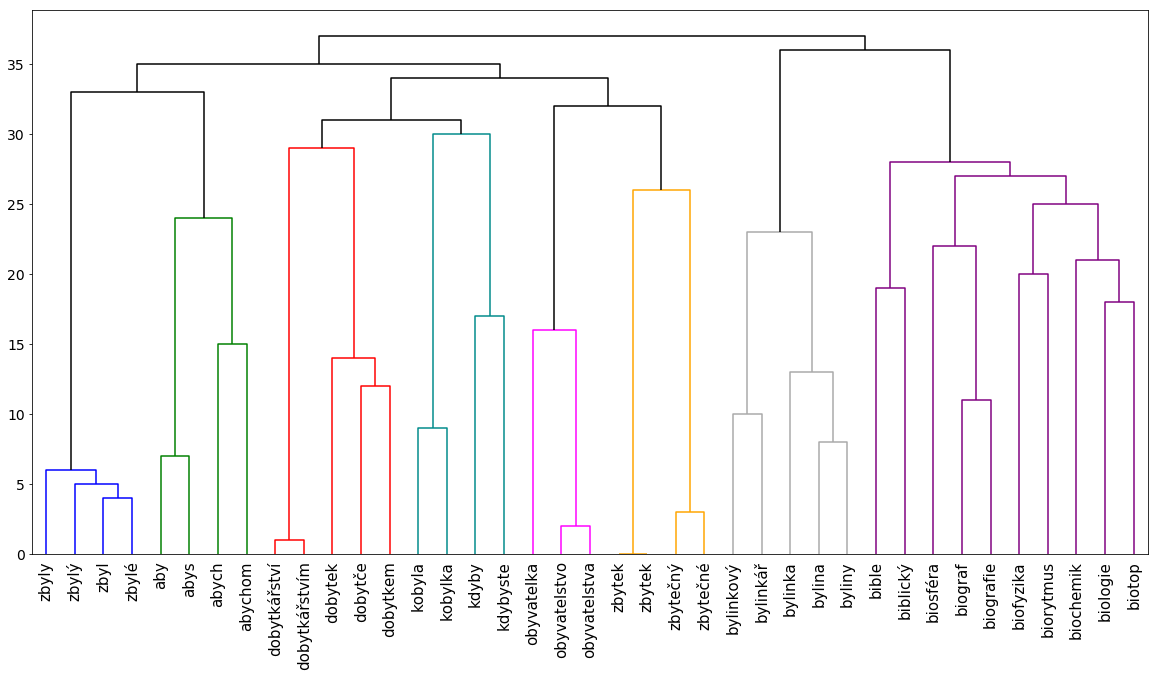

In [137]:
model = clustering.fit(editdistance)
#https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=editdistance.index, color_threshold=31, above_threshold_color='black', leaf_font_size=15, leaf_rotation=90)
plt.gcf().set_size_inches(20,10)
plt.yticks(fontsize=14)
# plt.ylabel('distance', fontsize=14)
plt.title('')
plt.savefig('hierarchicalclusteriing-editdistance-vyjmenovanaslovab.svg')
plt.show()

In [60]:
model = clustering.fit_predict(editdistance)

In [61]:
lol = pd.DataFrame({'label':model, 'word':word2vec.index})
lol.sort_values(['label'])

,label,word
19,0,kobylka
4,0,kdyby
5,0,kdybyste
18,0,kobyla
33,1,dobytkářstvím
32,1,dobytkem
11,1,dobytek
12,1,dobytče
13,1,dobytkářství
31,2,byliny
